In [57]:
import sklearn
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt

In [58]:
data = io.loadmat("ex4data1.mat")
X = data["X"]
y = data["y"]
print(X.shape)

(5000, 400)


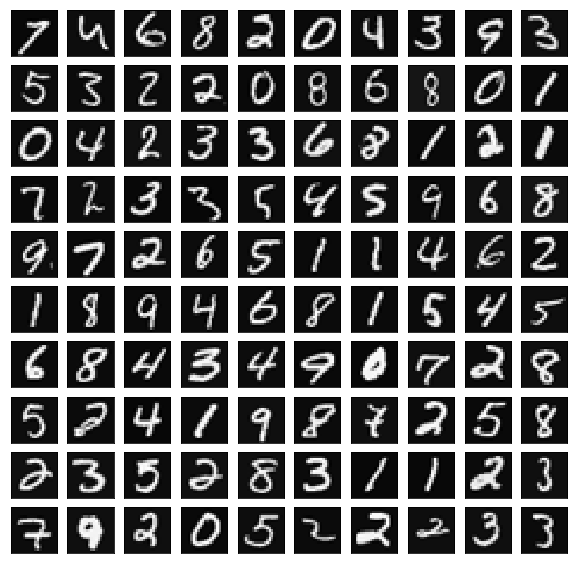

In [59]:
def plot_data():
    sample = np.random.choice(range(0, X.shape[0]), size= 100).flatten()
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.reshape(X[sample[i], :], (20, 20)).T, cmap="gray")
        ax.set(xticks=[], yticks=[])
plot_data()

In [60]:
def add_ones_column_to_X(X):
    new_X = np.ones((X.shape[0], X.shape[1] + 1))
    new_X[:, 1:] = X
    return new_X
X_ready = add_ones_column_to_X(X)
X_ready.shape

(5000, 401)

In [61]:
ex4_weights = io.loadmat("ex4weights.mat")
theta1_pre = ex4_weights["Theta1"]
theta2_pre = ex4_weights["Theta2"]

# Store the shape for the functions
thetas_shape = []
thetas_shape.append(theta1_pre.shape)
thetas_shape.append(theta2_pre.shape)
print(thetas_shape)

X_shape = X.shape
y_shape = y.shape

def reshape_thetas(thetas_flattened):
    thetas_ls = []
    left_point = 0
    for i in range(0, len(thetas_shape)):
        rows, columns = thetas_shape[i]
        theta_ar = np.reshape(thetas_flattened[left_point:left_point + rows*columns], (rows, columns))
        thetas_ls.append(theta_ar)
        left_point = rows*columns
    return thetas_ls

def reshape_X(X):
    return np.reshape(X, X_shape)

def reshape_y(y):
    return np.reshape(y, y_shape)

[(25, 401), (10, 26)]


In [62]:
y_new = y.copy()
y_new[y.flatten() == 10] = 0
y

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)

In [63]:
def transform_y_to_dummy_columns(y):
    # Can change this to deal with the matlab has no 0 vals and the y-value is 10
    y_true_vals = np.zeros((y.shape[0], np.max(y)))
    for i in range(0, y.shape[0]):
        y_true_vals[i, y[i] - 1] = 1
    return y_true_vals

In [64]:
from scipy.special import expit
def h(thetas_ls, X):
    """
    Theta will be a list of arrays,
    each array will be another theta
    for the system.
    """ 
    # First layers activation is X
    activation_vals = X.T
    
    for theta in thetas_ls:
        activation_vals = add_ones_column_to_X(activation_vals.T).T
        z = np.dot(theta, activation_vals)
        activation_vals = expit(z)
    return activation_vals.T
        
def nnCostFunction(theta_flattened, X, y):
    theta_ls = reshape_thetas(theta_flattened)
    X_ar = reshape_X(X)
    y_ar = reshape_y(y)
    
    number_of_output_nodes = np.max(y_ar)
    y_dum = transform_y_to_dummy_columns(y_ar)
    J = 0.0
    h_theta = h(theta_ls, X_ar)
    for k in range(0, number_of_output_nodes):
        first_term = -y_dum[:, k]*np.log(h_theta[:, k])
        second_term = - (1 - y_dum[:, k])*np.log(1 - h_theta[:, k])
        J +=first_term + second_term
    m = X_ar.shape[0]
    return np.sum(J)/m

theta_whole = [theta1_pre, theta2_pre]
h(theta_whole, X)

theta_flattened = list(theta1_pre.flatten()) + list(theta2_pre.flatten())
nnCostFunction(theta_flattened, X.flatten(), y.flatten())


0.2876291651613189

In [65]:
def nnCostRegularizationFunction(theta_flattened, X, y, lambda_val=1):
    theta_ls = reshape_thetas(theta_flattened)
    X_ar = reshape_X(X)
    y_ar = reshape_y(y)
    
    number_of_output_nodes = np.max(y_ar)
    y_dum = transform_y_to_dummy_columns(y_ar)
    J = 0.0
    h_theta = h(theta_ls, X_ar)
    for k in range(0, number_of_output_nodes):
        first_term = -y_dum[:, k]*np.log(h_theta[:, k])
        second_term = - (1 - y_dum[:, k])*np.log(1 - h_theta[:, k])
        J +=first_term + second_term
        
    m = X_ar.shape[0]
    J = np.sum(J)/m
    # For regularization
    for theta in theta_ls:
        J += lambda_val*np.sum(theta[:,1:]**2)/(2*m)
    return J

nnCostRegularizationFunction(theta_flattened, X.flatten(), y.flatten())

0.38376985909092365

In [66]:
def sigmoidGradient(z):
    return expit(z)*(1-expit(z))
print("0: {}".format(sigmoidGradient(0)))
print("infinity: {}".format(sigmoidGradient(np.inf)))
print("negative infinity: {}".format(sigmoidGradient(-np.inf)))
sigmoidGradient(np.zeros((2,2)))

0: 0.25
infinity: 0.0
negative infinity: 0.0


array([[0.25, 0.25],
       [0.25, 0.25]])

In [67]:
def obtainThetas(dimension, epsilon_init=0.12):
    theta_ls = []
    theta_ls = np.random.uniform(low=-epsilon_init, high=epsilon_init, size=dimension)
def feed_forward(thetas_ls, X):
    """
    Gives the activation of all but the input layer
    """
    activation_vals = X.T
    activation_vals_ls = []
    z_ls = []
    i=0
    for theta in thetas_ls:
        activation_vals = add_ones_column_to_X(activation_vals.T).T
        z = np.dot(theta, activation_vals)
        z_ls.append(z)
        activation_vals = expit(z)
        activation_vals_ls.append(activation_vals.T)
        i += 1
    return activation_vals_ls, z_ls

In [70]:
def random_thetas(size, epsilon=0.12):
    return np.random.uniform(low=-epsilon, high=epsilon, size=size)

def back_propagation(theta_flattened, X, y):
    theta_ls = reshape_thetas(theta_flattened)
    X_ar = reshape_X(X)
    y_ar = reshape_y(y)

    Delta1 = np.zeros((25, 400 + 1))
    Delta2 = np.zeros((10, 25 + 1))
    m = X_ar.shape[0]
    for i in range(0, m):        
        # Current row is a row vector
        current_row = np.reshape(X_ar[i, :], (1,400))
        
        activation_vals_ls, z_ls = feed_forward(theta_ls, current_row)
        current_row = add_ones_column_to_X(current_row)
        
        del_3 = np.reshape(activation_vals_ls[1], (-1, 1)) - np.reshape(transform_y_to_dummy_columns(y_ar)[i, :], (-1, 1))
        
        temp_grad = np.ones((z_ls[0].shape[0] + 1, z_ls[0].shape[1]))
        temp_grad[1:, :] = z_ls[0]
        del_2 = theta_ls[1].T.dot(del_3) * sigmoidGradient(temp_grad)
        
        activation_vals_ls[0] = add_ones_column_to_X(activation_vals_ls[0])
        Delta1 = Delta1 + del_2[1:, :].dot(current_row)
        Delta2 = Delta2 + del_3.dot(activation_vals_ls[0])
        
    Delta1 = Delta1/m
    Delta2 = Delta2/m
        
    return list(Delta1.flatten())+ list(Delta2.flatten())
        
back_propagation(theta_flattened, X.flatten(), y.flatten())

[6.187127661906803e-05,
 0.0,
 0.0,
 4.153368916624281e-09,
 -5.2986877274036004e-08,
 1.4218427155736565e-07,
 1.5971530837662485e-06,
 -8.899995500681516e-07,
 -1.4551306706259545e-06,
 -4.0895347011033775e-07,
 3.441294256698921e-07,
 1.3793228794671287e-07,
 -3.0539963945676234e-07,
 -6.730158373616632e-07,
 -2.2870488182369955e-07,
 -2.7044370389836157e-07,
 -7.627218646496509e-08,
 -8.255120165170291e-08,
 -6.549275945738918e-09,
 1.2741896326892146e-09,
 0.0,
 -1.2125267028371622e-11,
 2.8484525015808775e-10,
 -4.860462462419761e-08,
 4.524739589665981e-07,
 2.7394816286919725e-07,
 -1.2749541776305347e-06,
 -5.612835816917279e-06,
 -9.106097133274486e-06,
 -4.458169160823033e-06,
 -4.690672871431541e-06,
 -4.384395248036494e-07,
 5.185345075987823e-06,
 8.221042966755645e-06,
 1.3534400020041489e-06,
 1.495054718297513e-06,
 7.770766161291244e-07,
 -4.2563737767320127e-10,
 -2.129131393778724e-06,
 -1.970127903772581e-07,
 6.246899048766854e-08,
 1.4322736769893804e-10,
 -1.036